In [ ]:
https://drive.usercontent.google.com/download?id=1ZcoUkdCANHFIEYsXl-jiMSdiEOc91-Zk&export=download&authuser=0&confirm=t&uuid=4661d9e2-f599-43c2-9db1-8f7177a9e305&at=APvzH3ofsukcNR9ichjQICaWhQkG%3A173457436625

In [1]:
# 필요한 모듈 불러오기 및 시드 고정
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, ConvLSTM2D, Conv3D, BatchNormalization, Lambda, Reshape
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
# import data_preprocessing_codes.data_preprocessing as dpp
from keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
tf.random.set_seed(1)
np.random.seed(1)

2024-12-19 05:59:51.643925: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 05:59:51.643986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 05:59:51.644039: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 05:59:51.653716: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4090, compute capability 8.9


In [1]:
import requests

# 파일 URL
file_url = "https://drive.usercontent.google.com/download?id=1ZcoUkdCANHFIEYsXl-jiMSdiEOc91-Zk&export=download&authuser=0&confirm=t&uuid=4661d9e2-f599-43c2-9db1-8f7177a9e305&at=APvzH3ofsukcNR9ichjQICaWhQkG%3A173457436625"

# 요청하여 파일 다운로드
response = requests.get(file_url, stream=True)

# 파일이 성공적으로 다운로드되었는지 확인
if response.status_code == 200:
    # 파일 저장 경로
    save_path = "data_1hours_inputs_MEGA"
    with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):  # 청크 단위로 파일을 다운로드하여 메모리 절약
            file.write(chunk)
    print(f"파일이 성공적으로 다운로드되었습니다: {save_path}")
else:
    print(f"파일 다운로드 실패: {response.status_code}")

파일이 성공적으로 다운로드되었습니다: data_1hours_inputs_MEGA


In [5]:
inputs = np.load("data_1hours_inputs_MEGA")
outputs = np.load("data_1hours_outputs_MEGA.npy")

In [6]:
inputs.shape, outputs.shape

((690, 11, 40, 40, 4), (690, 1, 40, 40, 4))

In [17]:
# 자 모델 구축 들갑니다~
model = Sequential()
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     input_shape=(None,40,40,4), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, 
                     kernel_size=(3,3), 
                     padding="same", 
                     return_sequences=False))
model.add(Reshape((1, 40, 40, 40)))
model.add(BatchNormalization())
model.add(Conv3D(filters=4, 
                 kernel_size=(3,3,3), 
                 activation="sigmoid",
                 padding="same"))
optimizer = Adadelta(learning_rate=2.0)
model.compile(loss='binary_crossentropy',optimizer="adam", metrics = ['accuracy'])
callbacks_val_acc = [EarlyStopping(monitor='val_accuracy', patience=7, mode='max', restore_best_weights=True),
                     ModelCheckpoint("ClimateAI.keras", monitor='val_accuracy', save_best_only=True)]
callbacks_val_loss = [EarlyStopping(monitor='val_loss', patience=7, mode='min', restore_best_weights=True),
                      ModelCheckpoint("ClimateAI.keras", monitor='val_loss', save_best_only=True)]
callbacks = [callbacks_val_acc, callbacks_val_loss]

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 40, 40, 40   63520     
                             )                                   
                                                                 
 batch_normalization_4 (Bat  (None, None, 40, 40, 40   160       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 40, 40, 40   115360    
                             )                                   
                                                                 
 batch_normalization_5 (Bat  (None, None, 40, 40, 40   160       
 chNormalization)            )                                   
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, None, 40, 40, 40  

In [18]:
model.fit(inputs, outputs, epochs=10, batch_size=1, validation_split=0.1)

Epoch 1/10
621/621 [==============================] - 80s 118ms/step - loss: 0.4388 - accuracy: 0.9729 - val_loss: 0.4252 - val_accuracy: 0.9964
Epoch 2/10
621/621 [==============================] - 72s 117ms/step - loss: 0.4123 - accuracy: 0.9969 - val_loss: 0.4113 - val_accuracy: 0.9965
Epoch 3/10
621/621 [==============================] - 72s 116ms/step - loss: 0.4034 - accuracy: 0.9969 - val_loss: 0.4100 - val_accuracy: 0.9965
Epoch 4/10
621/621 [==============================] - 71s 114ms/step - loss: 0.3979 - accuracy: 0.9969 - val_loss: 0.4047 - val_accuracy: 0.9965
Epoch 5/10
621/621 [==============================] - 71s 115ms/step - loss: 0.3945 - accuracy: 0.9969 - val_loss: 0.4014 - val_accuracy: 0.9965
Epoch 6/10
621/621 [==============================] - 71s 115ms/step - loss: 0.3914 - accuracy: 0.9969 - val_loss: 0.3999 - val_accuracy: 0.9965
Epoch 7/10
621/621 [==============================] - 71s 115ms/step - loss: 0.3902 - accuracy: 0.9969 - val_loss: 0.3971 - val_ac

In [19]:
model.save("lgs-PB(14).keras")

In [20]:
loded_model = tf.keras.models.load_model("lgs-PB(14).keras")

In [7]:
test_data = inputs[:]
predict = loded_model.predict(test_data)
predict = predict.astype("float32")

22/22 [==============================] - 2s 42ms/step


In [8]:
predict.shape, test_data.shape

((690, 1, 40, 40, 4), (690, 11, 40, 40, 4))

In [9]:
def show_result(select_time):
    plt.figure(figsize=(30, 15))

    for i in range(11):
        plt.subplot(3, 6, i+1)
        plt.imshow(test_data[select_time, i, :, :, :])
        plt.xlabel(f"frame_{i+1}")

    plt.subplot(3, 6, 13)
    plt.imshow(predict[select_time, 0, :, :, :])
    plt.xlabel("prediction (frame_12)")
    plt.subplot(3, 6, 14)
    plt.imshow(outputs[select_time,0,:,:,:])
    plt.xlabel("Real data (frame_12)")
    plt.show()

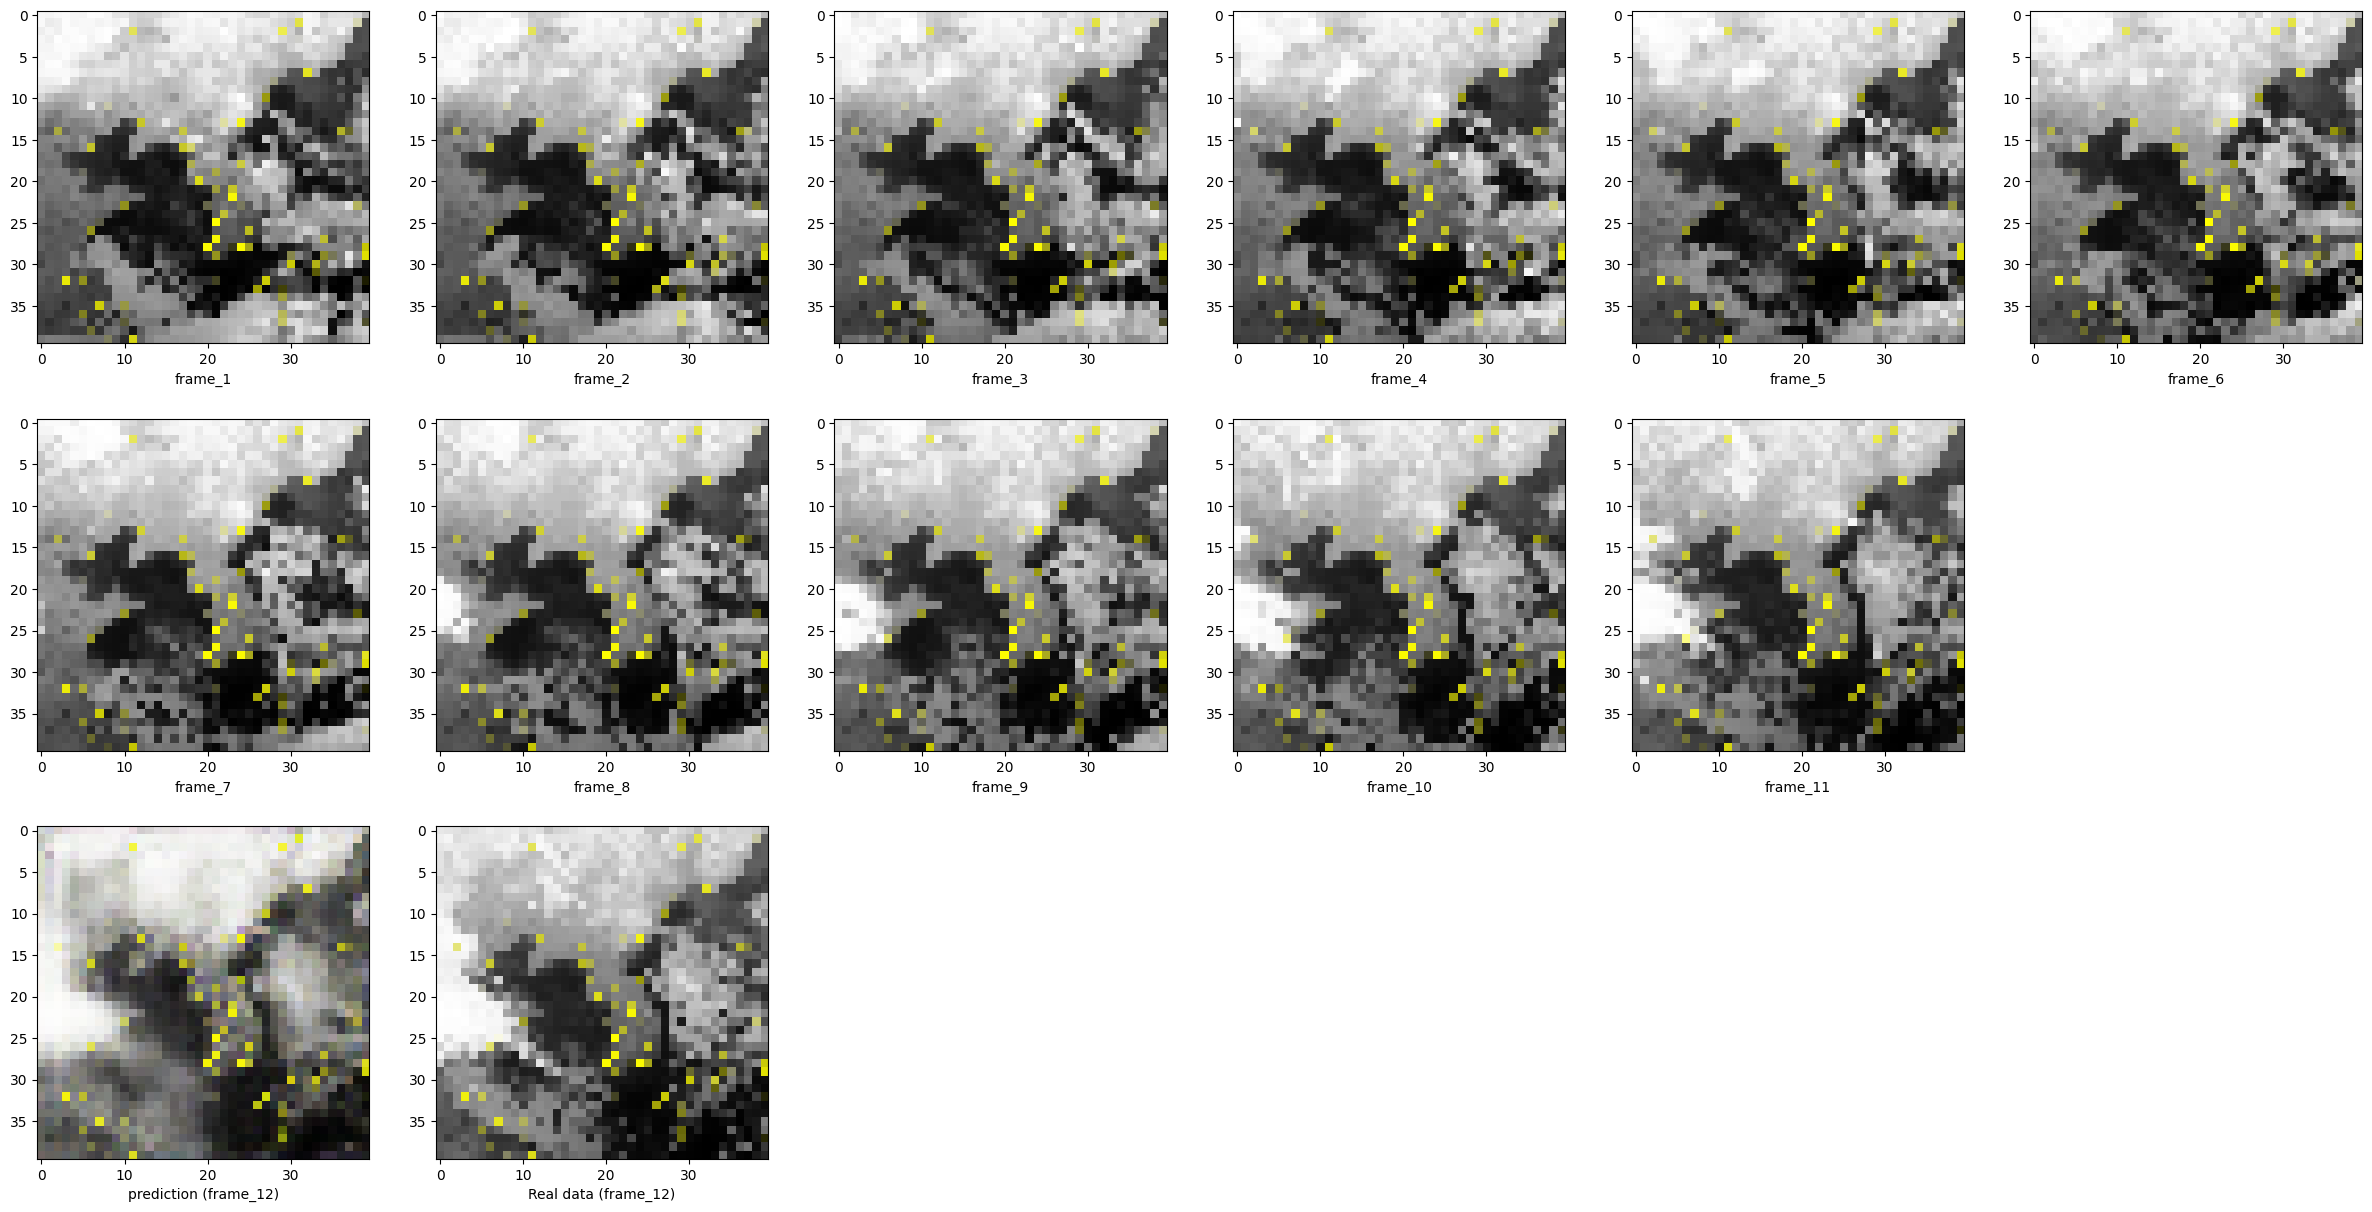

In [10]:
show_result(100)

In [ ]:
# 테스트 데이터로 검증 드가자

In [11]:
loded_model = tf.keras.models.load_model("lgs-PB(14).keras")

In [12]:
test_input = np.load("data_1hours_inputs_MEGA2.npy")
test_output = np.load("data_1hours_outputs_MEGA2.npy")

In [13]:
test_data = test_input
predict = loded_model.predict(test_data)
predict = predict.astype("float32")

2024-12-19 06:04:09.307952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-12-19 06:04:09.391956: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


3/3 [==============================] - 2s 73ms/step


In [14]:
def show_result_by_test_data(select_time, save_path=None):
    """
    Test data visualization function with optional saving.

    Parameters:
    - select_time (int): Index of the test data time step to visualize.
    - save_path (str, optional): Path to save the generated figure. If None, it won't save.
    """
    plt.figure(figsize=(30, 15))

    for i in range(11):
        plt.subplot(3, 6, i + 1)
        plt.imshow(test_data[select_time, i, :, :, :])
        plt.xlabel(f"frame_{i+1}")

    plt.subplot(3, 6, 13)
    plt.imshow(predict[select_time, 0, :, :, :])
    plt.xlabel("prediction (frame_12)")

    plt.subplot(3, 6, 14)
    plt.imshow(test_output[select_time, 0, :, :, :])
    plt.xlabel("Real data (frame_12)")

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Image saved to {save_path}")
    else:
        plt.show()

In [15]:
test_data.shape

(90, 11, 40, 40, 4)

Image saved to lgh-PB(14)-bestpredict-bytestdata2.png


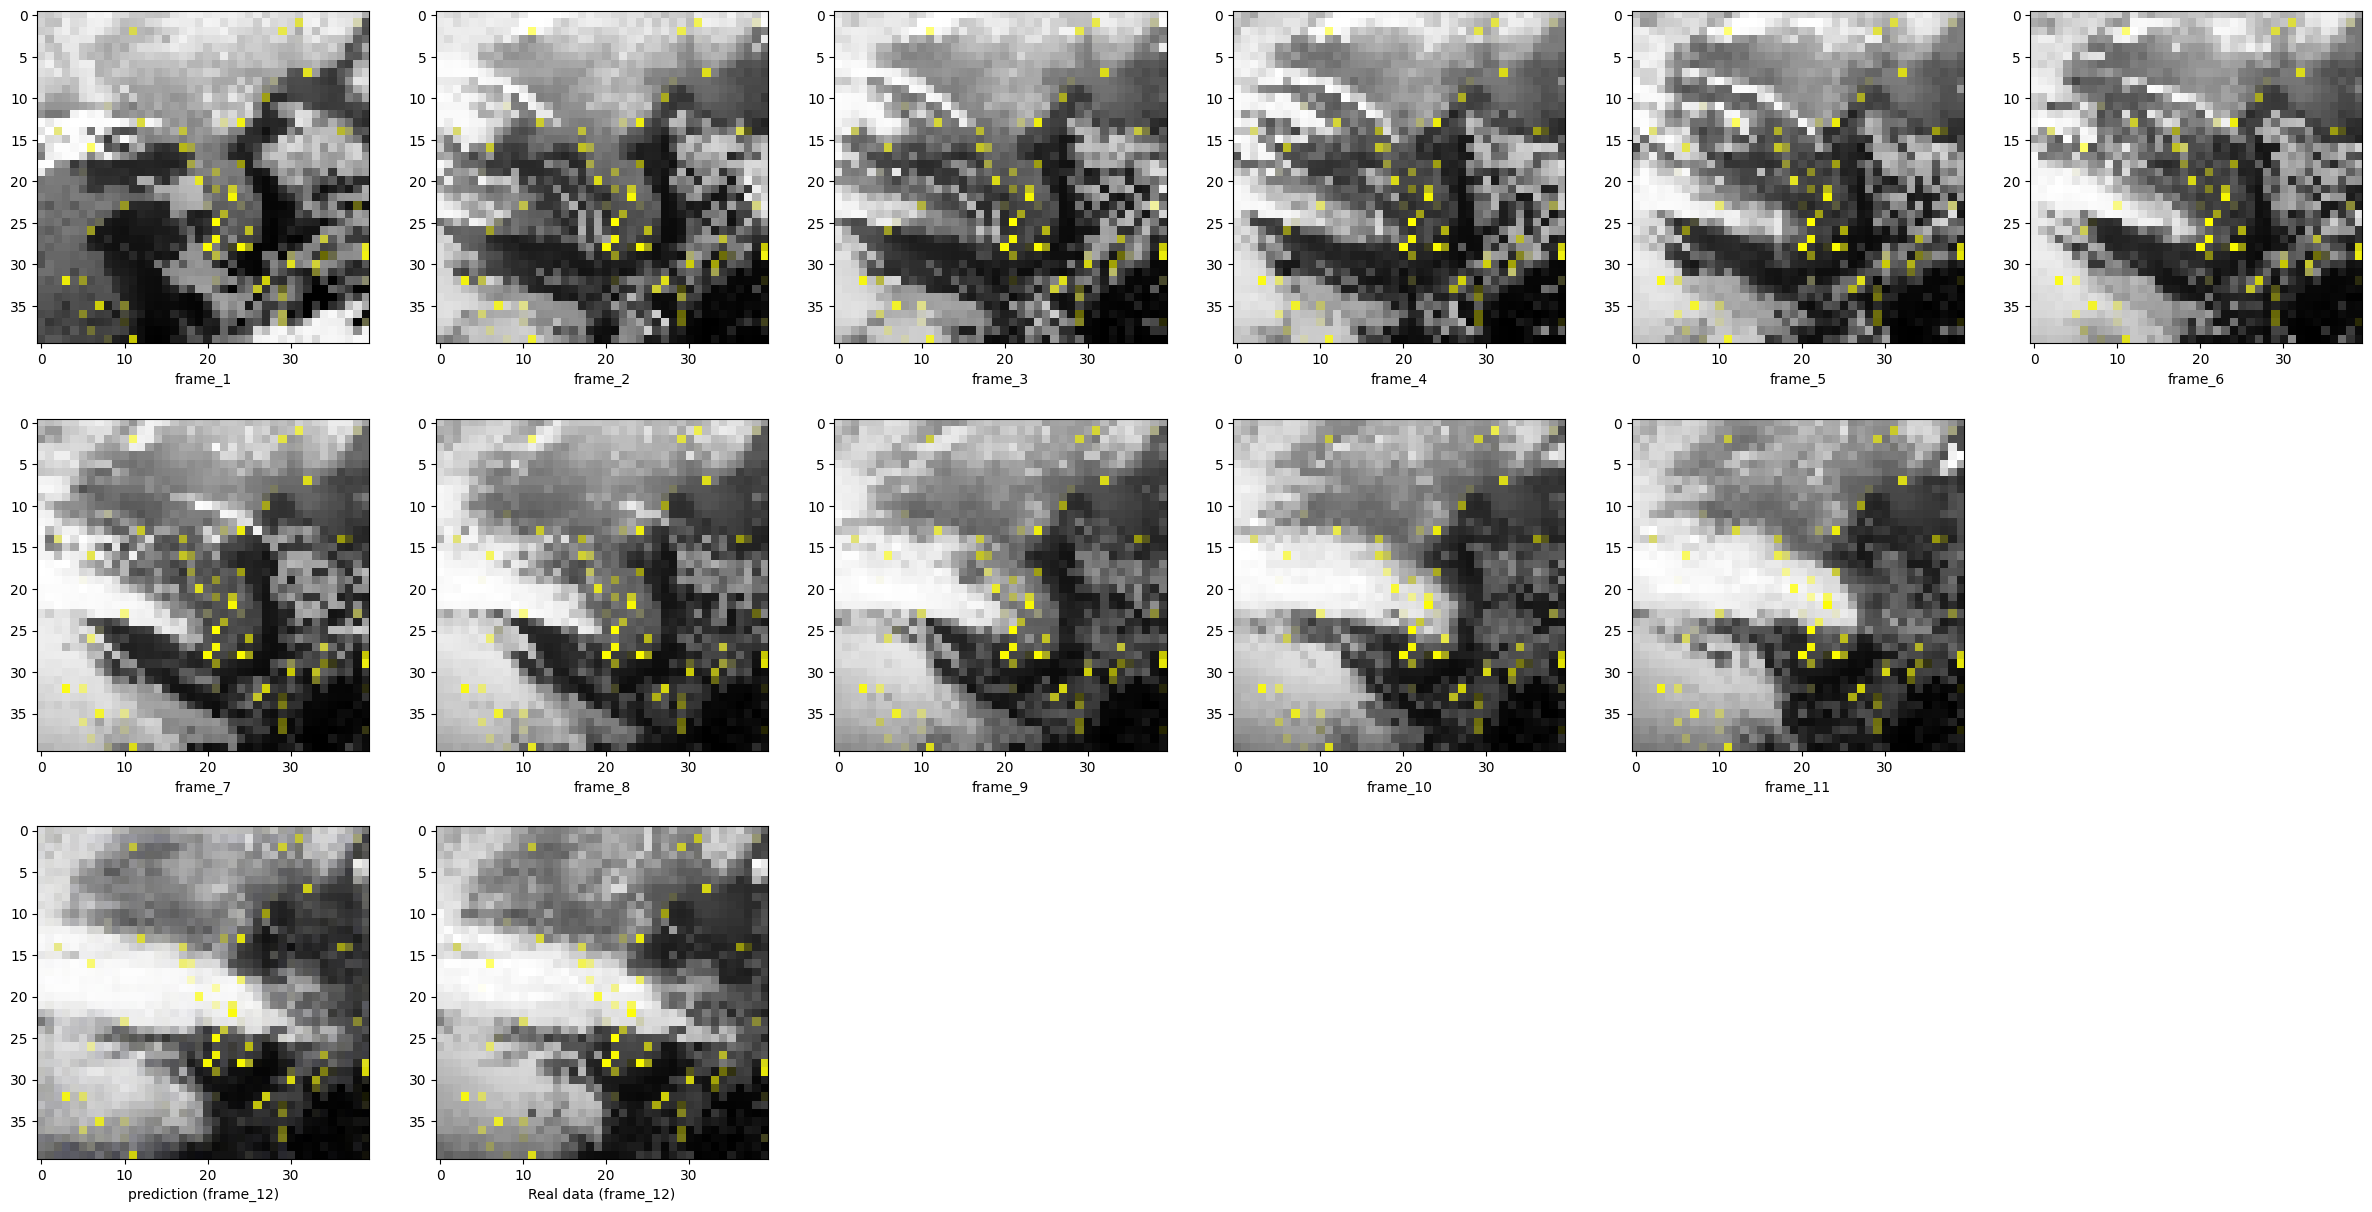

In [30]:
show_result_by_test_data(10,"lgh-PB(14)-bestpredict-bytestdata2.png")

Image saved to lgh-PB(14)-bestpredict-bytestdata3.png


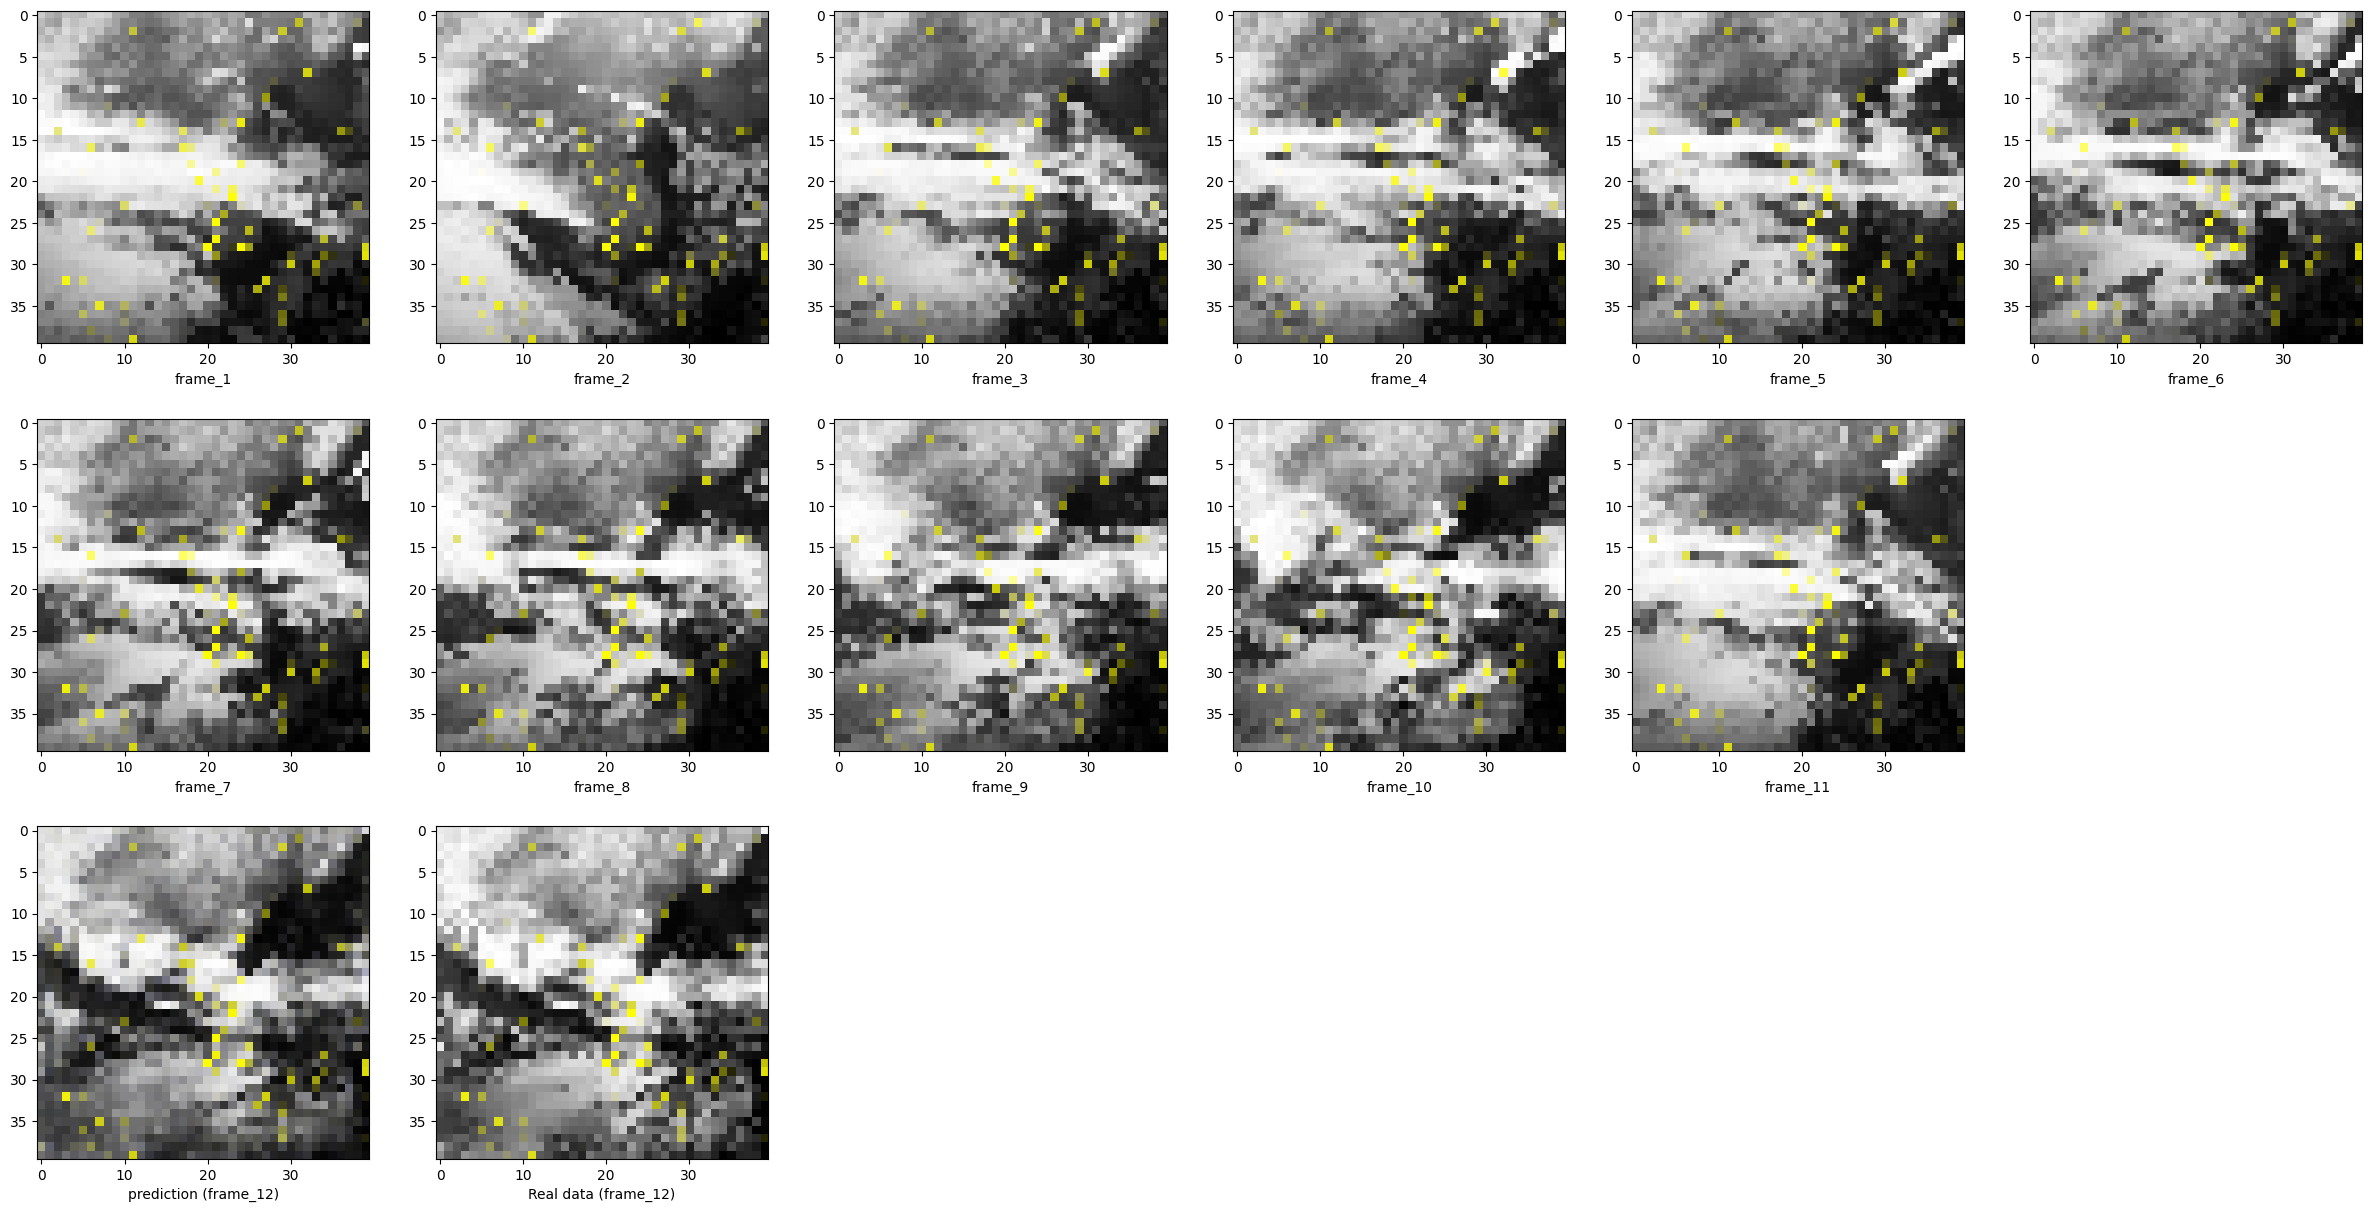

In [31]:
show_result_by_test_data(30,"lgh-PB(14)-bestpredict-bytestdata3.png")

Image saved to lgh-PB(14)-bestpredict-bytestdata4.png


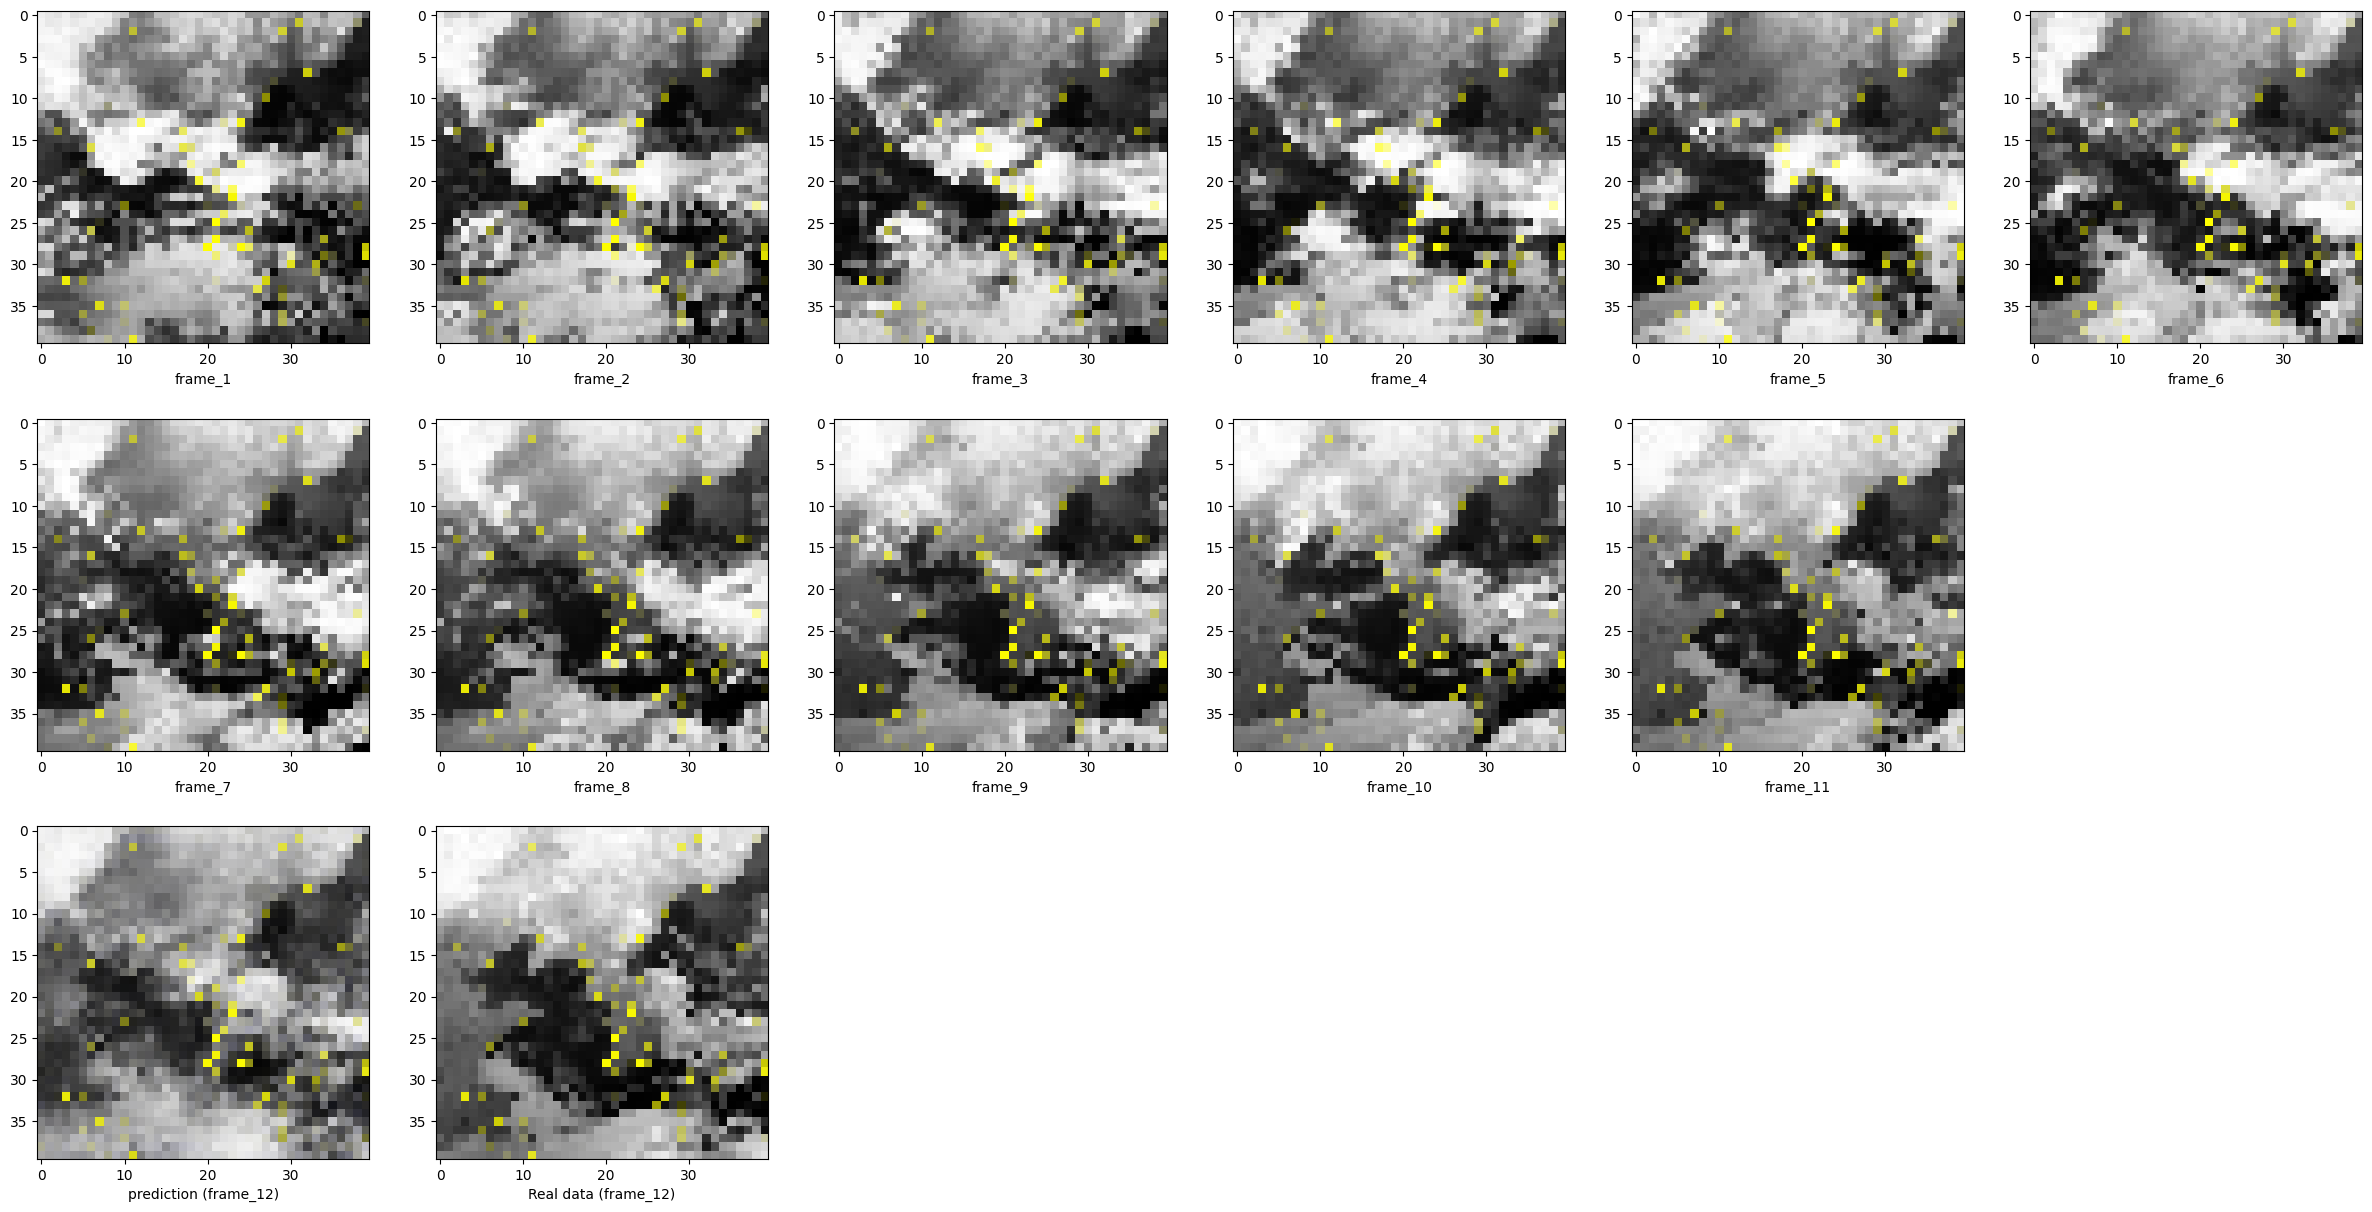

In [32]:
show_result_by_test_data(60,"lgh-PB(14)-bestpredict-bytestdata4.png")